In [1]:
import h5py
import numpy as np
from scipy.io import loadmat
from fw_i2cm1i_graphcut import fw_i2cm1i_graphcut
from fwFit_MixedLS_1r2star import fwFit_MixedLS_1r2star
from computeFF import computeFF
from create_robust_mask import create_robust_mask

In [2]:

# Open the HDF5 file
#file = h5py.File('/home/dxt005/home/Tools/WaterFatPython/Data/invivo_FF10p/IdealChanCombData_25544_4.h5', 'r')
#file = h5py.File('/home/dxt005/home/DATA/EXAM_6682_UWMR7.mr.med.ge.com_2024_05_14/IDEAL/IdealChanCombData_6682_2.h5', 'r')
file = h5py.File('/home/dxt005/home/Tools/WaterFatPython/Data/invivo/IdealChanCombData_16415_2.h5', 'r')


xres = file['Header']['ImageXRes'][0]
yres = file['Header']['ImageYRes'][0]
nslices = file['Header']['NumSlices'][0]
nTE = file['Header']['NumEchoes'][0]
TEs = file['Header']['EchoTimes'][0:nTE]
FieldStrength = file['Header']['FieldStrength'][0]

ims = np.zeros((xres, yres, nTE, nslices), dtype=np.cdouble)

# Iterate over each key
for sl in range(len(file['Data'].keys())):
    # Get the data
    key = 'Slice%d' % (sl)
    data = np.array(list(file['Data'][key]))
    data_c = data['real'] + 1j*data['imag']
    ims[:,:,:,sl] = data_c.transpose((2,1,0))

ims = ims/np.max(np.abs(ims))*100


In [3]:

# Setup params
PROCESS_PHANTOM = 0


fatAmps = np.array([0.087, 0.693, 0.128, 0.004, 0.039, 0.048])
fatFreq = np.array([-3.80, -3.40, -2.60, -1.94, -0.39, 0.60])
if PROCESS_PHANTOM==1:
	fatFreq = fatFreq - 0.08

algoParams = {
    'species': [
        {
            'name': 'water',
            'frequency': np.array([0.0]),
            'relAmps': np.array([1.0])
        },
        {
            'name': 'fat',
            'frequency': fatFreq,
            'relAmps': fatAmps
        }
    ],
    'size_clique':1,
    'range_r2star':np.array([0, 1000]),
    'NUM_R2STARS':11,
    'range_fm':np.array([-600, 600]),
    'NUM_FMS':101,
    'NUM_ITERS':40,
    'SUBSAMPLE':4,#4
    'DO_OT':0,
    'LMAP_POWER':2,
    'lambda':0.02,
    'LMAP_EXTRA':0.02,
    'TRY_PERIODIC_RESIDUAL':0
}

imDataParams = {
    'TE': TEs,
    'FieldStrength':FieldStrength/10000.0,
    'PrecessionIsClockwise': -1,
    'images':np.array([0, 0])
}

In [ ]:

import time

R2s3D = np.zeros((xres, yres, nslices))
PDFF3D = np.zeros((xres, yres, nslices))
Water3D = np.zeros((xres, yres, nslices))
Fat3D = np.zeros((xres, yres, nslices))

for sl in range(nslices):
#for sl in range(20,21):

    print('Slice %d'%(sl))
      
    imDataParams['images'] = ims[:,:,:,sl].reshape(xres, yres, 1, 1, nTE,1)
      
    mask = create_robust_mask(np.abs(ims[:,:,0,sl]), percentile_low=0, percentile_high=50)
    
    start = time.time()
    initParams = fw_i2cm1i_graphcut(imDataParams, algoParams)
    initParams['masksignal'] = mask
    end = time.time()
    print("Process Time initParams: %f" % (end - start))

    start = time.time()
    outParams = fwFit_MixedLS_1r2star(imDataParams, algoParams, initParams)
    end = time.time()
    print("Process Time fwFit_ComplexLS_1r2star: %f" % (end - start))
        
    Water3D[:,:,sl] =  np.abs(outParams['water_amp'])
    Fat3D[:,:,sl] =  np.abs(outParams['fat_amp'])
    R2s3D[:,:,sl] = outParams['r2starmap']
    PDFF3D[:,:,sl] = computeFF( outParams )


Slice 0
Process Time estimateR2starGivenFieldmap: 1.036682
Process Time decomposeGivenFieldMapAndDampings: 1.583012
Process Time initParams: 4.318828
Process Time fwFit_ComplexLS_1r2star: 3.205064
Slice 1
Process Time estimateR2starGivenFieldmap: 0.954156
Process Time decomposeGivenFieldMapAndDampings: 1.568456
Process Time initParams: 4.137626
Process Time fwFit_ComplexLS_1r2star: 2.913330
Slice 2
Process Time estimateR2starGivenFieldmap: 1.011015
Process Time decomposeGivenFieldMapAndDampings: 1.605181
Process Time initParams: 4.298838
Process Time fwFit_ComplexLS_1r2star: 2.689333
Slice 3
Process Time estimateR2starGivenFieldmap: 0.992294
Process Time decomposeGivenFieldMapAndDampings: 1.657945
Process Time initParams: 4.284064
Process Time fwFit_ComplexLS_1r2star: 2.835502
Slice 4
Process Time estimateR2starGivenFieldmap: 1.134203
Process Time decomposeGivenFieldMapAndDampings: 1.688014
Process Time initParams: 4.500185
Process Time fwFit_ComplexLS_1r2star: 2.899032
Slice 5
Process

Process Time estimateR2starGivenFieldmap: 0.972227
Process Time decomposeGivenFieldMapAndDampings: 1.597231
Process Time initParams: 4.169766
Process Time fwFit_ComplexLS_1r2star: 2.868815
Slice 29
Process Time estimateR2starGivenFieldmap: 1.000890
Process Time decomposeGivenFieldMapAndDampings: 1.611736
Process Time initParams: 4.246830
Process Time fwFit_ComplexLS_1r2star: 2.950473
Slice 30
Process Time estimateR2starGivenFieldmap: 1.223601
Process Time decomposeGivenFieldMapAndDampings: 1.616099
Process Time initParams: 4.420265
Process Time fwFit_ComplexLS_1r2star: 3.027969
Slice 31
Process Time estimateR2starGivenFieldmap: 0.999694
Process Time decomposeGivenFieldMapAndDampings: 1.594916
Process Time initParams: 4.172885


In [7]:
import ipywidgets as widgets
image_widget = widgets.Image(value=np.abs(Water3D[:,:,16]))

display(image_widget)


Image(value=b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00…

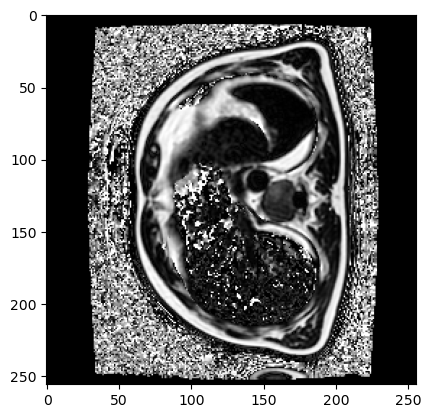

In [5]:
import matplotlib.pyplot as plt
plt.imshow(np.abs(PDFF3D[:,:,20]), cmap='gray',vmin=0, vmax=100)
plt.show()


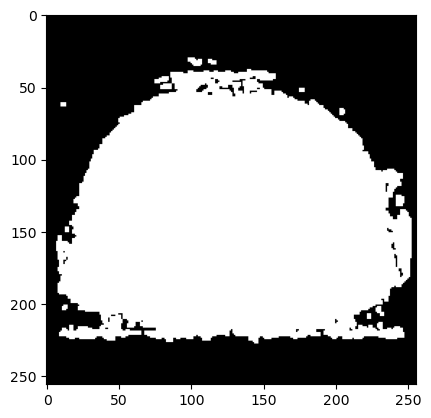

In [7]:
import matplotlib.pyplot as plt
plt.imshow(np.abs(initParams['masksignal']), cmap='gray',vmin=0, vmax=1)
plt.show()


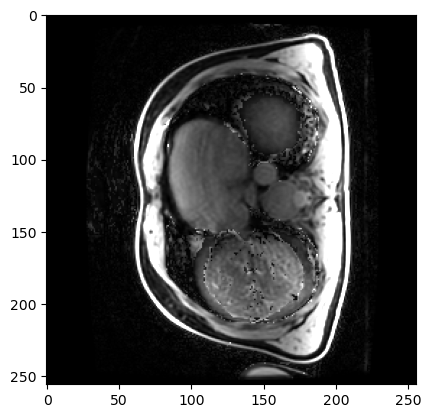

In [20]:
import matplotlib.pyplot as plt
plt.imshow(np.abs(outParams['water_amp']), cmap='gray',vmin=0, vmax=30)
plt.show()

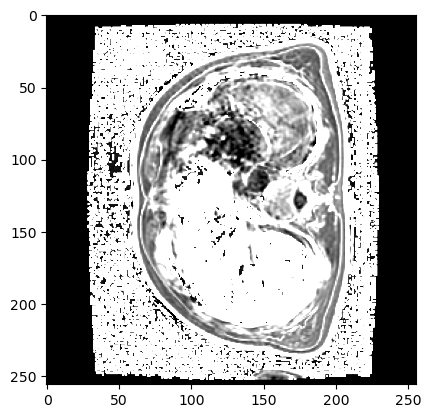

In [23]:

import matplotlib.pyplot as plt
plt.imshow(R2s3D[:,:,20], cmap='gray',vmin=0, vmax=100)
plt.show()


In [7]:
initParams['masksignal']

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00, -1.65841121e-10, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [10]:
initParams['masksignal']

array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,             nan,             nan],
       [            nan,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,             nan,             nan],
       ...,
       [            nan,  0.00000000e+00, -1.65841121e-10, ...,
         0.00000000e+00,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan]])